In [1]:
# 📘 תא “הוכחת ריצה” + קונפיגורציה בסיסית (תמיד ידפיס חותמת-זמן)
import sys, platform, datetime
print("=== NLP Text Processing Pipeline (20k subset) ===")
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("Run started at:", datetime.datetime.now().isoformat(timespec='seconds'))


=== NLP Text Processing Pipeline (20k subset) ===
Python: 3.13.5 | Platform: Windows-11-10.0.26100-SP0
Run started at: 2025-11-09T18:20:22


In [2]:
# תא 1 — טעינת ספריות ומשאבי NLTK
# 📘 טעינת ספריות ומשאבי NLTK (יורידו אוטומטית אם חסרים)
import pandas as pd
import re
from pathlib import Path

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

print("NLTK resources are ready.")


NLTK resources are ready.


In [3]:
# תא 2 — טעינת ה־Dataset, זיהוי עמודת ID ועמודות טקסט
# 📘 טעינת הדאטה, זיהוי עמודת ה-ID (אם קיימת), וזיהוי עמודות טקסט (object) לעיבוד
DATA_PATH = "hotpotqa_csv/train.csv"
print(f"Loading dataset from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", len(df))

# זיהוי עמודת ID
id_candidates = ['id', 'Id', 'ID']
ID_COL = next((c for c in id_candidates if c in df.columns), None)
print("ID column:", ID_COL if ID_COL else "None")

# עמודות טקסט (כל עמודה מסוג object חוץ מה-ID)
text_cols = [c for c in df.columns if df[c].dtype == 'object' and c != ID_COL]
print("Text columns to process:", text_cols if text_cols else "None")
if not text_cols:
    raise ValueError("No text columns found to process.")


Loading dataset from: hotpotqa_csv/train.csv
Loaded rows: 90425
ID column: id
Text columns to process: ['question', 'context', 'answer', 'level', 'type', 'quotes']


In [4]:
# תא 3 — סינון שורות לא ריקות ובחירה ב־20,000 שורות
# 📘 שמירה על שורות שבהן לפחות אחת מעמודות הטקסט אינה ריקה/ריקה-אחרי-strip
def non_empty_any(row):
    for c in text_cols:
        v = row[c]
        if isinstance(v, str) and v.strip():
            return True
    return False

print("Filtering rows to keep only those with at least one non-empty text column...")
mask = df.apply(non_empty_any, axis=1)
df = df[mask]

print("Rows after non-empty filter:", len(df))
df = df.head(20000)  # בחירה ב־20,000 שורות הראשונות
print("Rows capped at 20,000:", len(df))


Filtering rows to keep only those with at least one non-empty text column...
Rows after non-empty filter: 90425
Rows capped at 20,000: 20000


In [5]:
# תא 4 — פונקציות עיבוד: ניקוי, Lemmatization עם POS, והוצאת Stopwords
# 📘 פונקציות עיבוד טקסט לכל עמודה בנפרד:
#    - הסרת URL/Email/Handles
#    - טוקניזציה
#    - POS tagging + Lemmatization (עם מיפוי ל-WordNet)
#    - דילוג על שמות פרטיים (NNP/NNPS)
#    - נרמול צורות 'be' (am/is/are/was/were/been/being -> be)
#    - החלפת ספרות ב-_number
#    - הסרת תווים שאינם אותיות לטיניות/underscore/רווח
#    - הסרת stopwords
#    - הורדת רישיות
#
# הערה: לא נוצרים עמודות חדשות — הפונקציה תחזיר מחרוזת מעובדת שתחליף את תוכן העמודה.

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words('english'))
BE_FORMS = {"am","is","are","was","were","be","been","being"}

def get_wordnet_pos(tag: str):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

url_email_handle_re = re.compile(r'(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)', re.IGNORECASE)
digits_re = re.compile(r'\d+')           # ספרות -> _number
non_letter_re = re.compile(r'[^a-z_ ]+') # אחרי lowercase, נשאיר a-z, רווח, underscore

def process_text_value(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text

    # הסרה ראשונית של URL/Emails/Handles/Hashtags כדי לא להרוס POS
    t = url_email_handle_re.sub(' ', t)

    # טוקניזציה + POS על הטקסט המקורי (לפני lowercase) לטובת Proper Nouns טוב יותר
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    # Lemmatization עם POS + דילוג על Proper Nouns + נרמול 'be'
    lemmas = []
    for tok, pos in tagged:
        # נרמול מוקדם ל-be
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue
        if pos in ("NNP", "NNPS"):   # השארת שמות פרטיים כמו שהם
            lemmas.append(tok)
            continue
        wn_pos = get_wordnet_pos(pos)
        lemmas.append(lemmatizer.lemmatize(tok, wn_pos))

    # lowercase
    lemmas = [w.lower() for w in lemmas]

    # החלפת ספרות ל-_number (על טוקנים)
    lemmas = [digits_re.sub('_number', w) for w in lemmas]

    # שמירה רק על a-z/_/רווח — נסנן טוקנים שלא עומדים בזה
    clean_lemmas = []
    for w in lemmas:
        w2 = non_letter_re.sub(' ', w).strip()
        if not w2:
            continue
        # ייתכן שנוצרו רווחים; ניקח את ה"טוקן" הראשון (או נפרק לרבים)
        for part in w2.split():
            clean_lemmas.append(part)

    # הוצאת stopwords
    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # חיבור חזרה למחרוזת
    return " ".join(clean_lemmas)


In [6]:
# תא 5 — עיבוד כל עמודות הטקסט (ללא יצירת עמודות חדשות)
# 📘 עיבוד כל עמודות הטקסט בנפרד והחלפת התוכן בטקסט המעובד.
print("Processing text columns independently (no new columns will be added)...")

df_out = df.copy()
for c in text_cols:
    print(f"Processing column: {c}")
    df_out[c] = df_out[c].apply(process_text_value)

print("All text columns processed.")


Processing text columns independently (no new columns will be added)...
Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


In [7]:
# תא 6 — שמירה ל־CSV חדש (אותה סכימה, טקסטים אחרי עיבוד)
# 📘 שמירה ל-CSV חדש עם אותן עמודות; עמודות הטקסט כבר הוחלפו בגרסה לאחר העיבוד.
OUT_PATH = Path("hotpotqa_csv/processed_train_20k.csv")
df_out.to_csv(OUT_PATH, index=False, encoding='utf-8')
print(f"Processed CSV saved to: {OUT_PATH.resolve()}")
print("Done.")


Processed CSV saved to: C:\Users\mafil\hotpotqa_csv\processed_train_20k.csv
Done.


In [8]:
# תא 7 — בדיקת Before/After מהירה (על עמודת טקסט אחת לדוגמה)
# 📘 הדגמת Before/After מהירה (לצורכי אימות) — לא יוצרת עמודות חדשות
# נבחר את העמודה הטקסטואלית הראשונה והדפסה של 2 דוגמאות
demo_col = text_cols[0]
print(f"Demo on column: {demo_col}")

orig_samples = df[demo_col].head(2).tolist()
proc_samples = df_out[demo_col].head(2).tolist()

for i, (orig, proc) in enumerate(zip(orig_samples, proc_samples), start=1):
    print(f"\n🔸 Example {i}")
    print("Before:", str(orig)[:200])
    print("After: ", str(proc)[:200])


Demo on column: question

🔸 Example 1
Before: Which magazine was started first Arthur's Magazine or First for Women?
After:  magazine start first arthur magazine first women

🔸 Example 2
Before: The Oberoi family is part of a hotel company that has a head office in what city?
After:  oberoi family part hotel company head office city


🔹 Checking for categorical (label) columns...
Label column detected: type

Top categories:
type
bridge        16154
comparison     3846
Name: count, dtype: int64


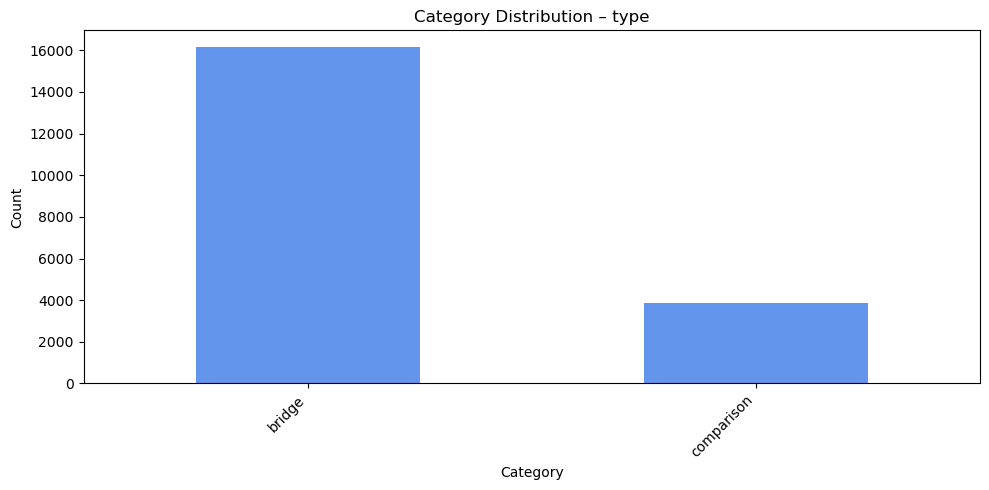


🔹 Found 'level' column – displaying its distribution...
level
medium    12515
easy       3984
hard       3501
Name: count, dtype: int64


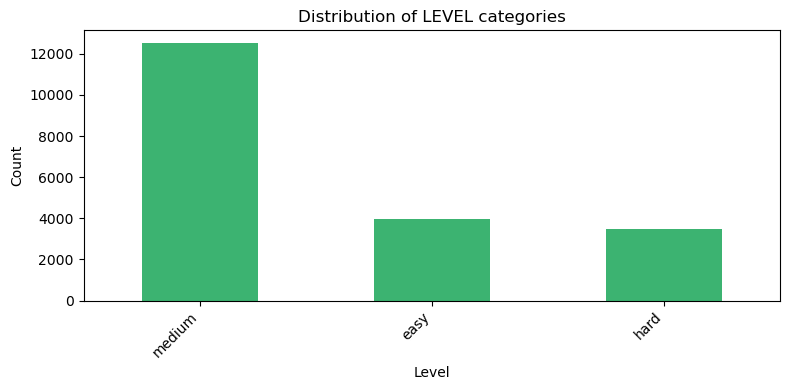

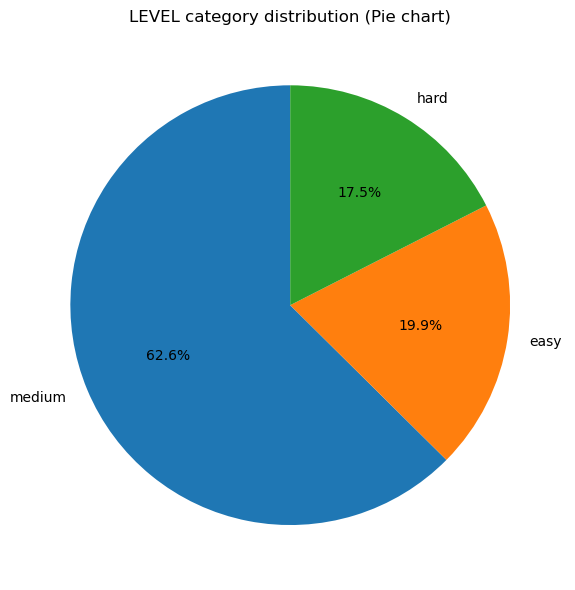


🔹 Text length histogram (in tokens):


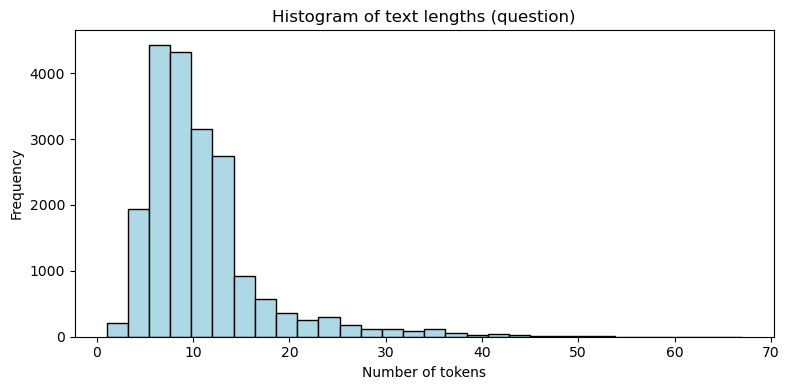

Average length: 10.69
Median length: 9.0

🔹 Most frequent tokens and bigrams:

Top 20 tokens:
_number         857177
film            100327
american        74463
first           60242
also            59495
album           54021
release         45474
one             44217
new             44133
know            43769
series          39942
play            39601
united          36604
song            36010
band            35107
year            35055
include         34110
name            33214
season          32392
bear            30767

Top 10 bigrams:
_number _number         197901
united states          28802
_number american        25410
new york            16129
september _number         13392
march _number         13268
may _number         13131
october _number         13104
january _number         13050
april _number         12674

🔹 Cleaning summary table (estimated):
(No detailed step metrics found in current notebook scope.)
Current dataset size: 20000 rows

🔹 Sample examples per ca

In [12]:
# תא – Exploratory & Visual Statistics
# 📊 סטטיסטיקות ויזואליות וניתוח ראשוני על הדאטה לאחר העיבוד
# ------------------------------------------------------------
# כולל:
# 1. גרף התפלגות קטגוריות כלליות (labels)
# 2. גרף מיוחד לעמודת 'level'
# 3. היסטוגרמת אורך טקסטים
# 4. רשימת מילים וביטויים שכיחים (unigrams/bigrams)
# 5. טבלת סיכום שלבים
# 6. דוגמאות איכות לפי קטגוריה
# ------------------------------------------------------------

import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams

plt.rcParams.update({'axes.unicode_minus': False})

# -----------------------------------
# 1. גרף התפלגות קטגוריות כלליות
# -----------------------------------
print("🔹 Checking for categorical (label) columns...")
candidate_labels = ['label','category','topic','type','sentiment','class','answer']
label_col = next((c for c in candidate_labels if c in df_out.columns and df_out[c].notna().any()), None)

if label_col:
    print(f"Label column detected: {label_col}")
    label_counts = df_out[label_col].astype(str).value_counts()
    print("\nTop categories:")
    print(label_counts.head(10))

    plt.figure(figsize=(10,5))
    label_counts.plot(kind='bar', color='cornflowerblue')
    plt.title(f"Category Distribution – {label_col}")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No generic label column detected — skipping label distribution plot.")

# -----------------------------------
# 2. גרף לעמודת LEVEL
# -----------------------------------
if 'level' in df_out.columns:
    print("\n🔹 Found 'level' column – displaying its distribution...")

    level_counts = df_out['level'].astype(str).value_counts()
    print(level_counts.head(10))

    # גרף עמודות
    plt.figure(figsize=(8,4))
    level_counts.plot(kind='bar', color='mediumseagreen')
    plt.title("Distribution of LEVEL categories")
    plt.xlabel("Level")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # גרף עוגה (אם יש לא יותר מדי קטגוריות)
    if len(level_counts) <= 10:
        plt.figure(figsize=(6,6))
        plt.pie(level_counts.values, labels=level_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title("LEVEL category distribution (Pie chart)")
        plt.show()
else:
    print("\nNo 'level' column found — skipping LEVEL charts.")

# -----------------------------------
# 3. היסטוגרמת אורך טקסטים
# -----------------------------------
print("\n🔹 Text length histogram (in tokens):")

def count_tokens(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

text_col = next((c for c in df_out.columns if c not in ['id','Id','ID','level',label_col] and df_out[c].dtype=='object'), None)
if text_col:
    df_out['text_length'] = df_out[text_col].apply(count_tokens)
    plt.figure(figsize=(8,4))
    plt.hist(df_out['text_length'], bins=30, color='lightblue', edgecolor='black')
    plt.title(f"Histogram of text lengths ({text_col})")
    plt.xlabel("Number of tokens")
    plt.ylabel("Frequency")
    plt.show()

    print("Average length:", round(df_out['text_length'].mean(),2))
    print("Median length:", round(df_out['text_length'].median(),2))
else:
    print("No text column detected for histogram.")

# -----------------------------------
# 4. רשימת מילים וביטויים שכיחים
# -----------------------------------
print("\n🔹 Most frequent tokens and bigrams:")
tokens = []
for c in df_out.columns:
    if df_out[c].dtype == 'object' and c not in [label_col,'level']:
        for text in df_out[c].dropna():
            tokens.extend(text.split())

token_counts = Counter(tokens)
top_tokens = token_counts.most_common(20)
print("\nTop 20 tokens:")
for w, f in top_tokens:
    print(f"{w:<15} {f}")

bigrams = list(ngrams(tokens, 2))
bigram_counts = Counter(bigrams)
top_bigrams = bigram_counts.most_common(10)
print("\nTop 10 bigrams:")
for (a,b), f in top_bigrams:
    print(f"{a} {b:<15} {f}")

# -----------------------------------
# 5. טבלת סיכום ניקוי (אם קיימת)
# -----------------------------------
print("\n🔹 Cleaning summary table (estimated):")
try:
    summary
    display(summary)
except NameError:
    print("(No detailed step metrics found in current notebook scope.)")
    print(f"Current dataset size: {len(df_out)} rows")

# -----------------------------------
# 6. דוגמאות איכות לפי קטגוריה
# -----------------------------------
print("\n🔹 Sample examples per category:")
target_col = label_col or ('level' if 'level' in df_out.columns else None)
if target_col:
    for cat in df_out[target_col].astype(str).unique()[:5]:  # עד 5 קטגוריות
        print(f"\nCategory: {cat}")
        samples = df_out[df_out[target_col].astype(str) == cat][text_col].dropna().head(2)
        for i, s in enumerate(samples, start=1):
            print(f" Example {i}: {s[:250]}")
else:
    print("No label or level column available for examples.")


